# LibCBM versus CBM-CFS3 Stand level testing

In [1]:
import os, json, math
import numpy as np
import pandas as pd
%matplotlib inline


libCBM related imports


In [2]:
from libcbm.test import casegeneration
from libcbm.test.cbm3support import cbm3_simulator
from libcbm.test import simulator
from libcbm.test import poolcomparison

In [3]:
age_interval=5
num_age_classes = 40 #required by cbm3
n_steps = 250
cbm3_exe_path = r"M:\CBM Tools and Development\Builds\CBMBuilds\20190530_growth_increment_fix"
toolbox_path = r"C:\Program Files (x86)\Operational-Scale CBM-CFS3"
archive_index_db_path = r"C:\Program Files (x86)\Operational-Scale CBM-CFS3\Admin\DBs\ArchiveIndex_Beta_Install.mdb"

cbm_defaults_db_path = 'C:\dev\cbm_defaults\cbm_defaults.db'
libcbm_path = r'C:\dev\LibCBM\build\LibCBM\Release\LibCBM.dll'

generate random test cases

In [4]:
cases = casegeneration.generate_scenarios(
    random_seed = 1,
    num_cases = 10,
    dbpath = 'C:\dev\cbm_defaults\cbm_defaults.db',
    n_steps=n_steps,
    max_disturbances = 3,
    max_components = 1,
    growth_generator = lambda: casegeneration.get_random_sigmoid_func,
    n_growth_digits = 2,
    age_interval=age_interval,
    growth_curve_len=age_interval*num_age_classes)


In [5]:
libcbm_result = simulator.run_libCBM(libcbm_path, cbm_defaults_db_path, cases, n_steps, spinup_debug=True)

In [6]:

project_path = cbm3_simulator.import_cbm3_project(
    name="stand_level_testing",
    cases=cases,
    age_interval=age_interval,
    num_age_classes=num_age_classes,
    nsteps=n_steps,
    cbm_exe_path=cbm3_exe_path,
    toolbox_path=toolbox_path,
    archive_index_db_path=archive_index_db_path)

cbm3_results_path = cbm3_simulator.run_cbm3(
    aidb_path=archive_index_db_path, 
    project_path=project_path,
    toolbox_path=toolbox_path,
    cbm_exe_path=cbm3_exe_path)

cbm3_result = cbm3_simulator.get_cbm3_results(cbm3_results_path)

In [9]:
pools_merged, pool_diffs = poolcomparison.join_pools(libcbm_result["pools"], cbm3_result["pools"], "all")

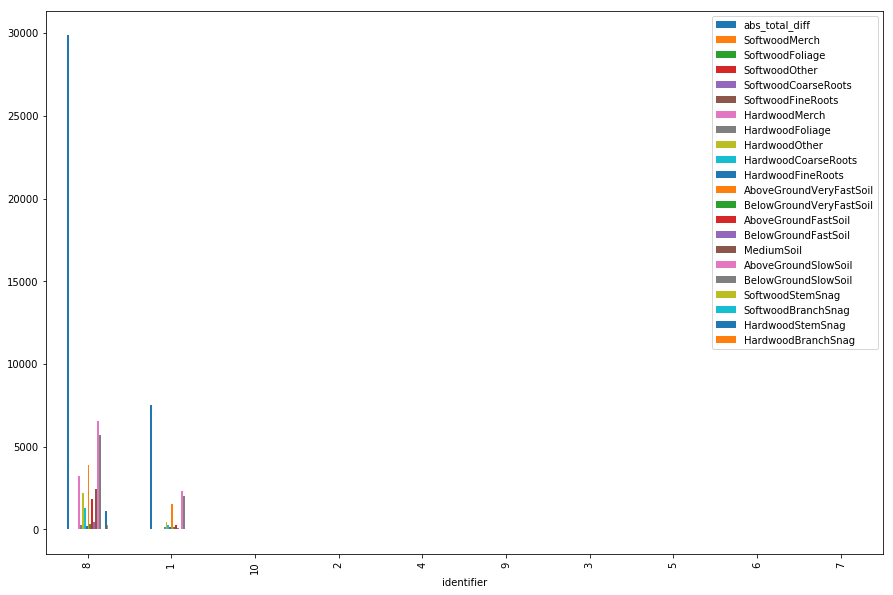

In [10]:
pool_diffs_totals = pool_diffs.drop(columns="timestep")
pool_diffs_totals \
    .groupby("identifier").sum() \
    .sort_values("abs_total_diff", ascending=False) \
    .head(20) \
    .plot(figsize=(15,10), kind="bar")

In [11]:
def plot_diff(id):
    markers = ["o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d"]
    bio_pools = pools_merged[pools_merged["identifier"]==casegeneration.get_classifier_name(id)]
    bio_pools = bio_pools.drop(columns="identifier")
    bio_pools = bio_pools.groupby("timestep").sum()
    ax = bio_pools.plot(figsize=(12,10), title=casegeneration.get_classifier_name(id))
    for i, line in enumerate(ax.get_lines()):
        line.set_marker(markers[i%len(markers)])
    ax.legend(ax.get_lines(), bio_pools.columns, loc='best')
    bio_diffs = pool_diffs[pool_diffs["identifier"]==casegeneration.get_classifier_name(id)]
    bio_diffs.drop(columns="identifier")
    bio_diffs.groupby("timestep").sum() \
        .plot(figsize=(12,10), title=casegeneration.get_classifier_name(id))

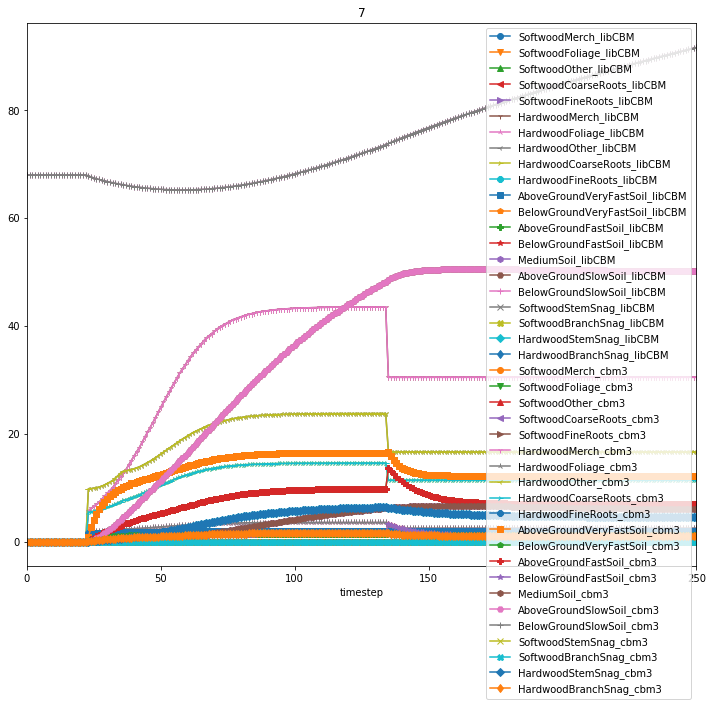

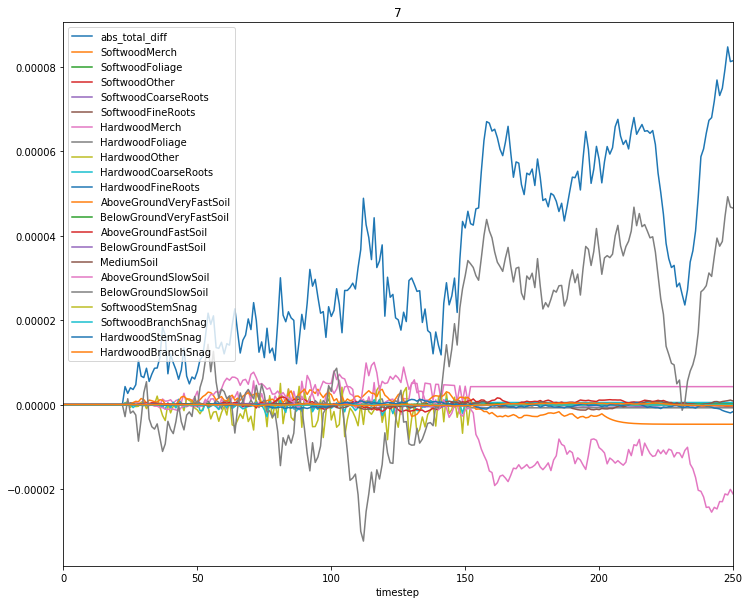

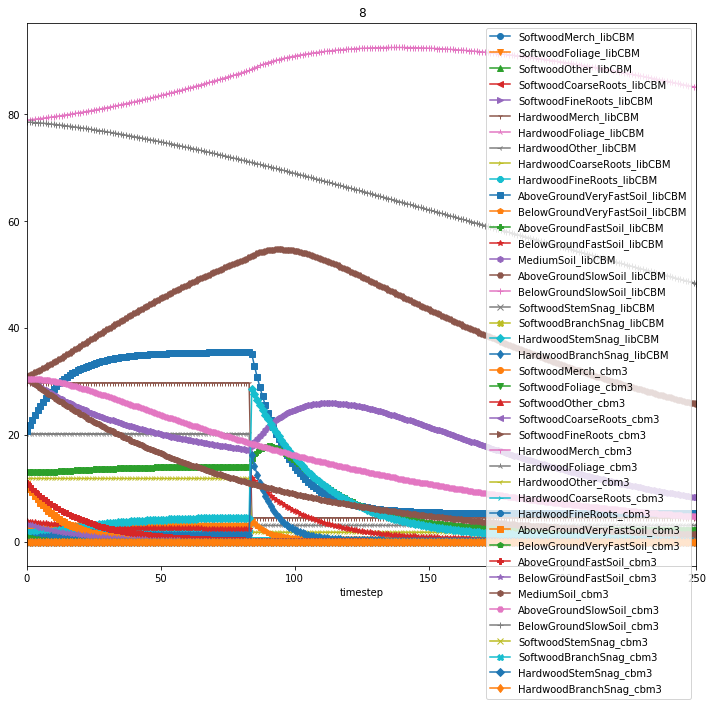

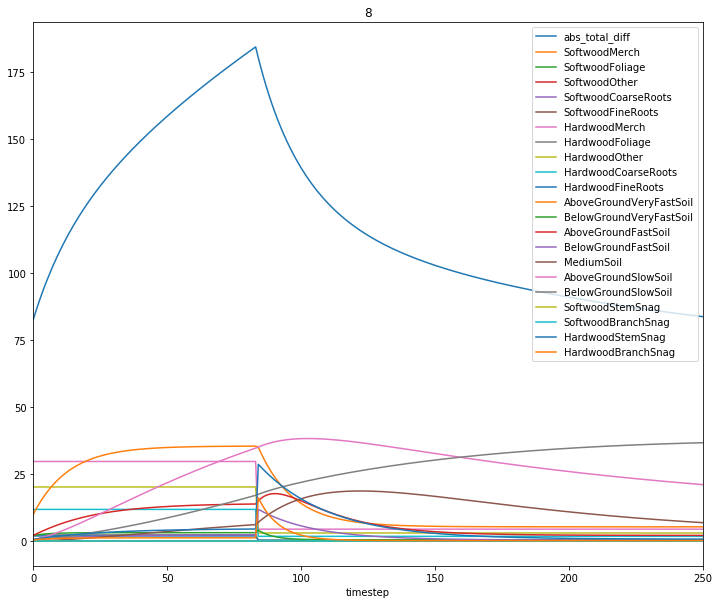

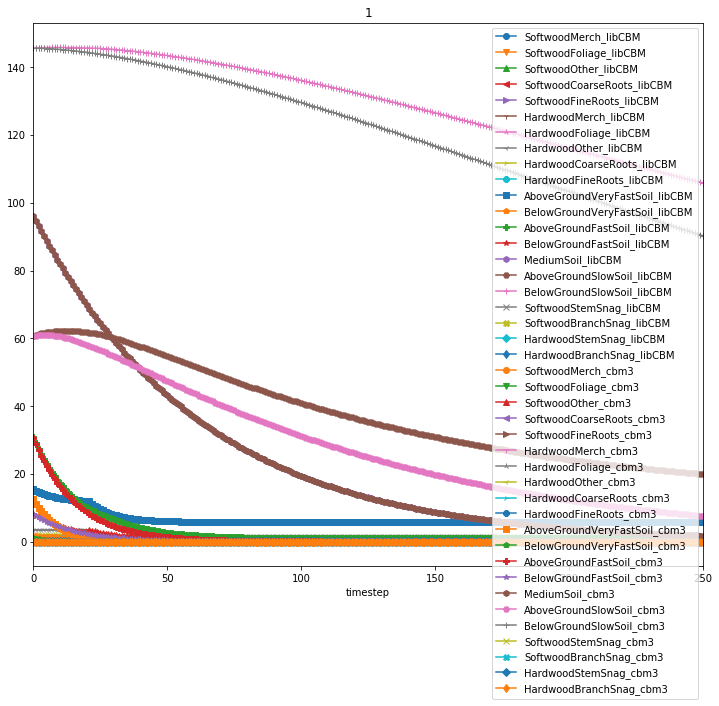

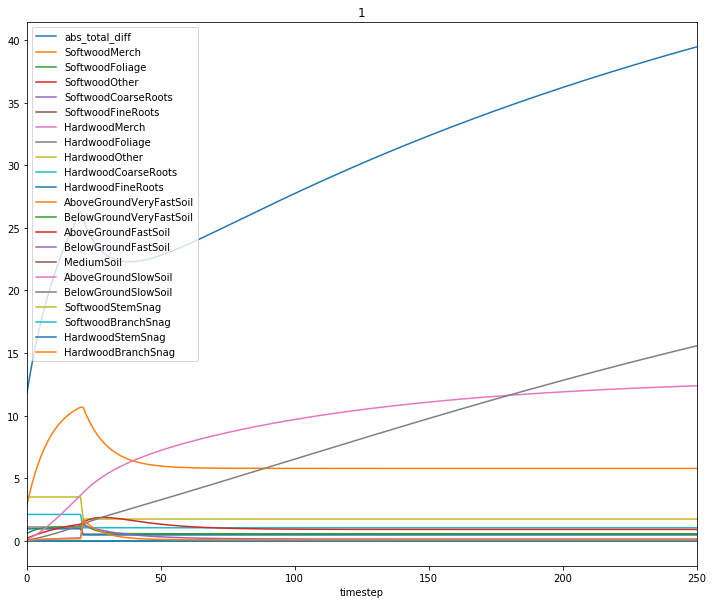

In [12]:
plot_diff(7)
plot_diff(8)
plot_diff(1)

Spinup debug


In [13]:
cases[7]

{'id': 8,
 'age': 0,
 'area': 1.0,
 'delay': 8,
 'afforestation_pre_type': None,
 'unfccc_land_class': 'UNFCCC_FL_R_OL',
 'admin_boundary': 'Manitoba',
 'eco_boundary': 'Taiga Shield West',
 'historic_disturbance': 'Wildfire',
 'last_pass_disturbance': 'Deforestation',
 'components': [{'species': 'Cucumber-tree',
   'age_volume_pairs': [(0, 0.0),
    (5, 59.34),
    (10, 59.74),
    (15, 59.75),
    (20, 59.75),
    (25, 59.75),
    (30, 59.75),
    (35, 59.75),
    (40, 59.75),
    (45, 59.75),
    (50, 59.75),
    (55, 59.75),
    (60, 59.75),
    (65, 59.75),
    (70, 59.75),
    (75, 59.75),
    (80, 59.75),
    (85, 59.75),
    (90, 59.75),
    (95, 59.75),
    (100, 59.75),
    (105, 59.75),
    (110, 59.75),
    (115, 59.75),
    (120, 59.75),
    (125, 59.75),
    (130, 59.75),
    (135, 59.75),
    (140, 59.75),
    (145, 59.75),
    (150, 59.75),
    (155, 59.75),
    (160, 59.75),
    (165, 59.75),
    (170, 59.75),
    (175, 59.75),
    (180, 59.75),
    (185, 59.75),
    (

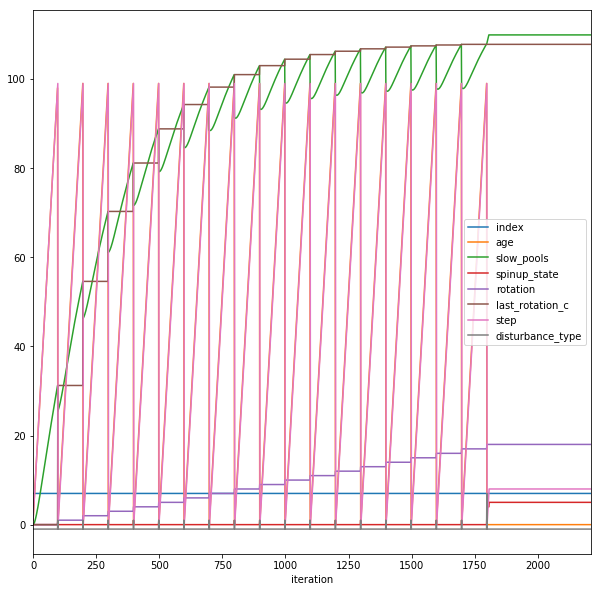

In [14]:


if "spinup_debug" in libcbm_result:
    libCBM_spinup_debug = libcbm_result["spinup_debug"]
    libCBM_spinup_debug[libCBM_spinup_debug["index"]==7].groupby("iteration").sum().plot(figsize=(10,10))

In [15]:
libcbm_pools = libcbm_result["pools"]

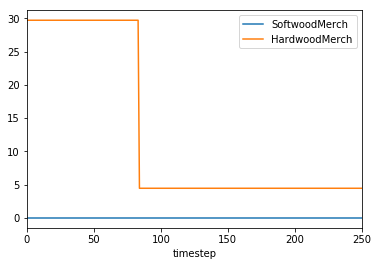

In [16]:
libcbm_pools[libcbm_pools["identifier"]=="8"][["timestep","SoftwoodMerch","HardwoodMerch"]].groupby("timestep").sum().plot()

In [19]:
cbm3_pools = cbm3_result["pools"]

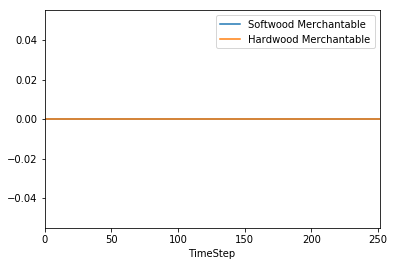

In [20]:
cbm3_pools[cbm3_pools["identifier"]=="8"] \
    [["TimeStep","Softwood Merchantable","Hardwood Merchantable"]] \
    .groupby("TimeStep").sum().plot()

In [21]:
libcbm_state_variables = libcbm_result["state_variable_result"]

In [23]:
libcbm_state_variables[libcbm_state_variables["identifier"]=='8']

,identifier,timestep,age,land_class,last_disturbance_type,time_since_last_disturbance,time_since_land_class_change,growth_enabled,growth_multipliers,regeneration_delay,disturbance_types,enabled
7,8,0,0,16,7,8,8,0,1.0,0,0,1
7,8,1,0,16,7,10,8,0,1.0,0,0,1
7,8,2,0,16,7,12,8,0,1.0,0,0,1
7,8,3,0,16,7,14,8,0,1.0,0,0,1
7,8,4,0,16,7,16,8,0,1.0,0,0,1
7,8,5,0,16,7,18,8,0,1.0,0,0,1
7,8,6,0,6,7,0,8,0,1.0,0,0,1
7,8,7,0,6,7,1,8,0,1.0,0,0,1
7,8,8,0,6,7,2,8,0,1.0,0,0,1
7,8,9,0,6,7,3,8,0,1.0,0,0,1
